<a href="https://colab.research.google.com/github/Aayushh/Twitter_Machine_Learning/blob/main/Toxic_comments_EDA_modelling_proj.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Introduction:
Being anonymous over the internet can sometimes make people say nasty things that they normally would not in real life.
Let's filter out the hate from our platforms one comment at a time. 

## Objective:
You’re challenged to build a multi-headed model that’s capable of detecting different types of of toxicity like threats, obscenity, insults, and identity-based hate better than Perspective’s current models. 

## Data Overview:
The dataset here is from wiki corpus dataset which was rated by human raters for toxicity.
The corpus contains 63M comments from discussions relating to user pages and articles dating from 2004-2015. 

Different platforms/sites can have different standards for their toxic screening process. Hence the comments are tagged in the following five categories
* toxic
* severe_toxic
* obscene
* threat
* insult
* identity_hate

The tagging was done via **crowdsourcing** which means that the dataset was rated by different people and the tagging might not be 100% accurate too. The same concern is being discussed [here](https://www.kaggle.com/c/jigsaw-toxic-comment-classification-challenge/discussion/46131).


In [ ]:
#import required packages
#basics
import pandas as pd 
import numpy as np

#misc
import gc
import time
import warnings

#stats
#from scipy.misc import imread
from scipy import sparse
import scipy.stats as ss

#viz
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec 
import seaborn as sns
from wordcloud import WordCloud ,STOPWORDS
from PIL import Image
import matplotlib_venn as venn

#nlp
import string
import re    #for regex
import nltk
import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords
import spacy
from nltk import pos_tag
from nltk.stem.wordnet import WordNetLemmatizer 
from nltk.tokenize import word_tokenize
# Tweet tokenizer does not split at apostophes which is what we want
from nltk.tokenize import TweetTokenizer   


#FeatureEngineering
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer, HashingVectorizer
from sklearn.decomposition import TruncatedSVD
from sklearn.base import BaseEstimator, ClassifierMixin
from sklearn.utils.validation import check_X_y, check_is_fitted
from sklearn.linear_model import LogisticRegression
from sklearn import metrics
from sklearn.metrics import log_loss
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import train_test_split





#settings
start_time=time.time()
color = sns.color_palette()
sns.set_style("dark")
eng_stopwords = set(stopwords.words("english"))
warnings.filterwarnings("ignore")

lem = WordNetLemmatizer()
tokenizer=TweetTokenizer()

%matplotlib inline

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


In [ ]:
# Load the data

from google.colab import drive

drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
#importing the dataset
train=pd.read_csv("/content/drive/MyDrive/NLP/jigsaw/train.csv")
test=pd.read_csv("/content/drive/MyDrive/NLP/jigsaw/test.csv")

In [ ]:
#take a peak
train.tail()

,id,comment_text,toxic,severe_toxic,obscene,threat,insult,identity_hate
159566,ffe987279560d7ff,""":::::And for the second time of asking, when ...",0,0,0,0,0,0
159567,ffea4adeee384e90,You should be ashamed of yourself \n\nThat is ...,0,0,0,0,0,0
159568,ffee36eab5c267c9,"Spitzer \n\nUmm, theres no actual article for ...",0,0,0,0,0,0
159569,fff125370e4aaaf3,And it looks like it was actually you who put ...,0,0,0,0,0,0
159570,fff46fc426af1f9a,"""\nAnd ... I really don't think you understand...",0,0,0,0,0,0


In [ ]:
nrow_train=train.shape[0]
nrow_test=test.shape[0]
sum=nrow_train+nrow_test
print("       : train : test")
print("rows   :",nrow_train,":",nrow_test)
print("perc   :",round(nrow_train*100/sum),"   :",round(nrow_test*100/sum))

       : train : test
rows   : 159571 : 153164
perc   : 51    : 49


There is a 30:70 train: test split and the test set might change in the future too.

Let's take a look at the class imbalance in the train set.

### Class Imbalance:

In [ ]:
x=train.iloc[:,2:].sum()

#marking comments without any tags as "clean"
rowsums=train.iloc[:,2:].sum(axis=1)
train['clean']=(rowsums==0) 
#count number of clean entries
train['clean'].sum()
print("Total comments = ",len(train))
print("Total clean comments = ",train['clean'].sum())
print("Total tags =",x.sum())

Total comments =  159571
Total clean comments =  143346
Total tags = 35098


In [ ]:
train.head()

,id,comment_text,toxic,severe_toxic,obscene,threat,insult,identity_hate,clean
0,0000997932d777bf,Explanation\nWhy the edits made under my usern...,0,0,0,0,0,0,True
1,000103f0d9cfb60f,D'aww! He matches this background colour I'm s...,0,0,0,0,0,0,True
2,000113f07ec002fd,"Hey man, I'm really not trying to edit war. It...",0,0,0,0,0,0,True
3,0001b41b1c6bb37e,"""\nMore\nI can't make any real suggestions on ...",0,0,0,0,0,0,True
4,0001d958c54c6e35,"You, sir, are my hero. Any chance you remember...",0,0,0,0,0,0,True


In [ ]:
#task 1: Tell me how much null values in train and test and fill the comment text with 'unknown'
train.isnull().sum()
test.isnull().sum()

id              0
comment_text    0
dtype: int64

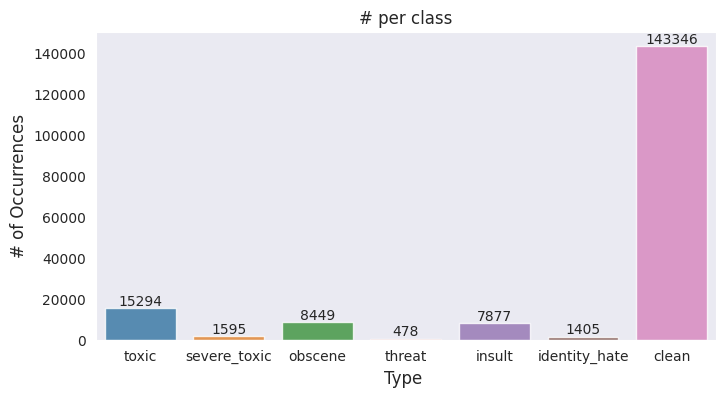

In [ ]:
#visualise how many comments in which category
x=train.iloc[:,2:].sum()
#plot
plt.figure(figsize=(8,4))
ax= sns.barplot(x=x.index, y=x.values, alpha=0.8)
plt.title("# per class")
plt.ylabel('# of Occurrences', fontsize=12)
plt.xlabel('Type ', fontsize=12)
#adding the text labels
rects = ax.patches
labels = x.values
for rect, label in zip(rects, labels):
    height = rect.get_height()
    ax.text(rect.get_x() + rect.get_width()/2, height + 5, label, ha='center', va='bottom')

plt.show()

* The toxicity is not evenly spread out across classes. Hence we might face class imbalance problems
* Multiple tags are associated with each comment (eg) a comment can be classified as both toxic and obscene. 

### Multi-tagging:
Let's check how many comments have multiple tags.

<Axes: >

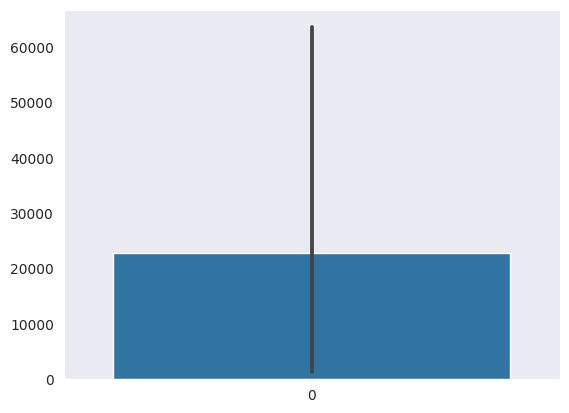

In [ ]:
#task2 : Tell me how many comments are multitagged. Plot them visually in a bar 
x=rowsums.value_counts()


##Which tags go together?
####Now let's have a look at how often the tags occur together.
* Confusion matrix/Crosstab


In [ ]:
temp_df = x

In [ ]:
#Crosstab
# Since technically a crosstab between all 6 classes is impossible to vizualize, lets take a 
# look at toxic with other tags
main_col="toxic"
corr_mats=[]
for other_col in temp_df.columns[1:]:
    confusion_matrix = pd.crosstab(temp_df[main_col], temp_df[other_col])
    corr_mats.append(confusion_matrix)
out = pd.concat(corr_mats,axis=1,keys=temp_df.columns[1:])

#cell highlighting
#out = out.style.apply(highlight_min,axis=0)
out

AttributeError: ignored

The above table represents the Crosstab/ consufion matix of Toxic comments with the other classes. 

Some interesting observations:

* A Severe toxic comment is always toxic
* Other classes seem to be a subset of toxic barring a few exceptions




## Example Comments:

In [ ]:
print("toxic:")
print(train[train.severe_toxic==1].iloc[9,1])
#print(train[train.severe_toxic==1].iloc[5,1])

toxic:
WOULDN'T BE THE FIRST TIME BITCH. FUCK YOU I'LL FIND OUT WHERE YOU LIVE, SODOMIZE YOUR WIFE AND THEN BURN YOUR HOUSE DOWN. FUCK YOU YOU FUCKING QUEER.


In [ ]:
print("severe_toxic:")
print(train[train.severe_toxic==1].iloc[9,1])
#print(train[train.severe_toxic==1].iloc[4,1])

severe_toxic:
WOULDN'T BE THE FIRST TIME BITCH. FUCK YOU I'LL FIND OUT WHERE YOU LIVE, SODOMIZE YOUR WIFE AND THEN BURN YOUR HOUSE DOWN. FUCK YOU YOU FUCKING QUEER.


In [ ]:
print("Threat:")
print(train[train.threat==1].iloc[9,1])
#print(train[train.threat==1].iloc[2,1])

Threat:
You are a gay homo. I hope you choke on your penis and die. I am sending a big bleck guy to jizz in your face.


In [ ]:
print("Obscene:")
print(train[train.obscene==1].iloc[9,1])
#print(train[train.obscene==1].iloc[2,1])

Obscene:
I think that your a Fagget get a oife and burn in Hell I hate you 'm sorry we cant have any more sex i'm running out of conndoms


In [ ]:
print("identity_hate:")
print(train[train.identity_hate==1].iloc[9,1])
#print(train[train.identity_hate==1].iloc[4,1])

identity_hate:
WOULDN'T BE THE FIRST TIME BITCH. FUCK YOU I'LL FIND OUT WHERE YOU LIVE, SODOMIZE YOUR WIFE AND THEN BURN YOUR HOUSE DOWN. FUCK YOU YOU FUCKING QUEER.





# Wordclouds - Frequent words:

Now, let's take a look at words that are associated with these classes.

   Chart Desc: The visuals here are word clouds (ie) more frequent words appear bigger. A cool way to create word clouds with funky pics is given [here](https://www.kaggle.com/arthurtok/spooky-nlp-and-topic-modelling-tutorial). It involves the following steps.
    * Search for an image and its base 64 encoding
    * Paste encoding in a cell and convert it using codecs package to image
    * Create word cloud with the new image as a mask
A simpler way would be to create a new kaggle dataset and import images from there.
    

In [ ]:
!ls ../input/imagesforkernal/
stopword=set(STOPWORDS)

ls: cannot access '../input/imagesforkernal/': No such file or directory


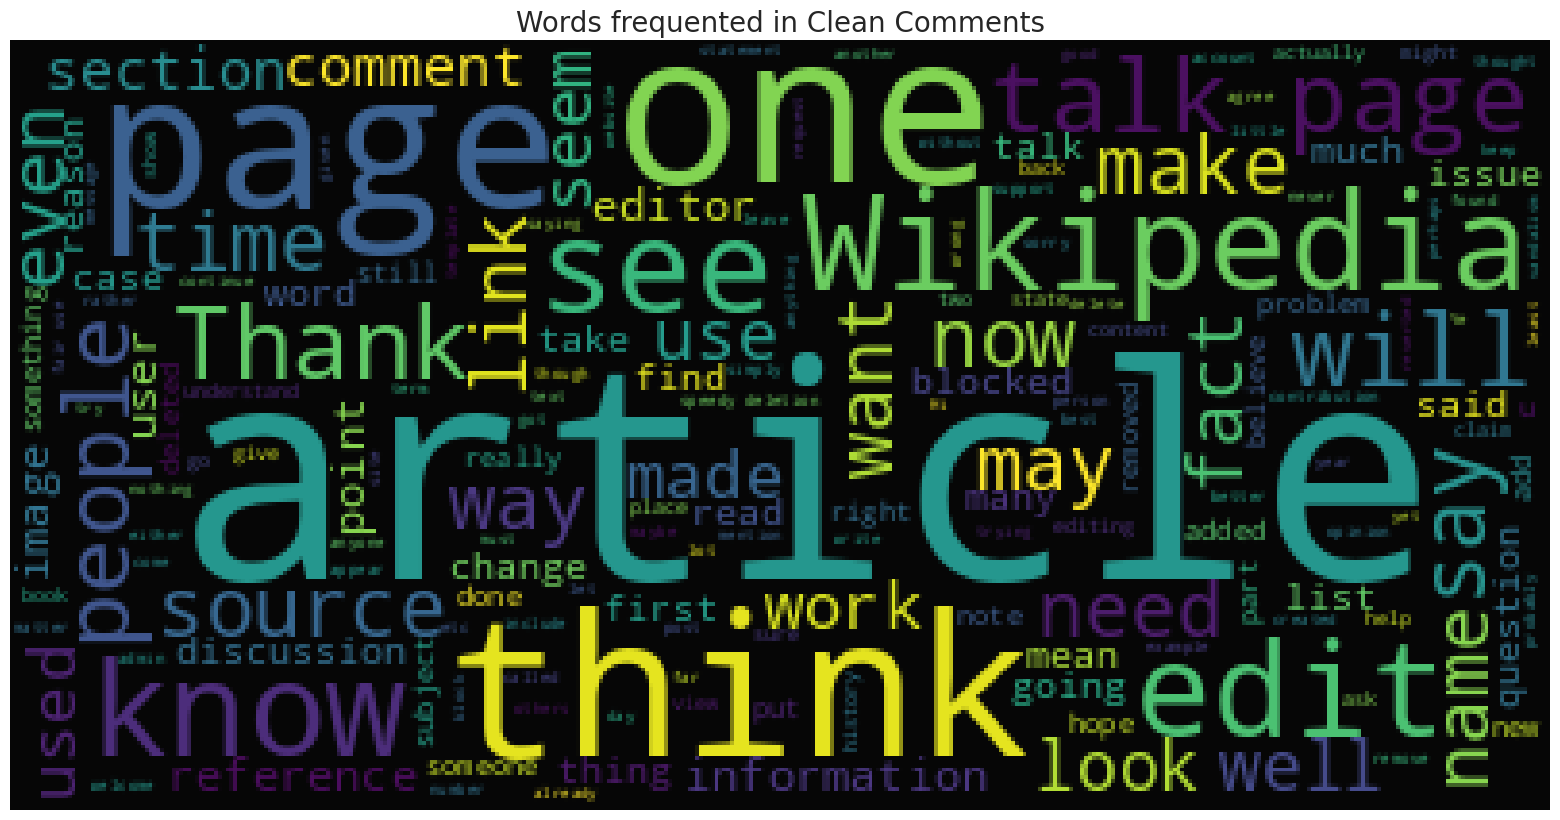

In [ ]:
#clean comments
#clean_mask=np.array(Image.open("../input/imagesforkernal/safe-zone.png"))
#clean_mask=clean_mask[:,:,1]
#wordcloud for clean comments
subset=train[train.clean==True]
text=subset.comment_text.values
wc= WordCloud(background_color="black",max_words=2000,stopwords=stopword)
wc.generate(" ".join(text))
plt.figure(figsize=(20,10))
plt.axis("off")
plt.title("Words frequented in Clean Comments", fontsize=20)
plt.imshow(wc.recolor(colormap= 'viridis' , random_state=17), alpha=0.98)
plt.show()

In [ ]:
for col_name, col_data in train.iteritems():
  print(col_name)

id
comment_text
toxic
severe_toxic
obscene
threat
insult
identity_hate
clean


In [ ]:
#task3: make a word cloud for each of the categories above and see the most frequently occuring words
for col_name, col_data in train.iteritems():
  subset=train[train.col_name==1]
  text=subset.comment_text.values
  wc= WordCloud(background_color="black",max_words=2000,stopwords=stopword)
  wc.generate(" ".join(text))
  plt.figure(figsize=(20,10))
  plt.axis("off")
  plt.title("Words frequented in Clean Comments", fontsize=20)
  plt.imshow(wc.recolor(colormap= 'viridis' , random_state=17), alpha=0.98)
  plt.show()

AttributeError: ignored

# Feature engineering:
I've broadly classified my feature engineering ideas into the following three groups
## Direct features:
Features which are a directly due to words/content.We would be exploring the following techniques
* Word frequency features
    * Count features
    * Bigrams
    * Trigrams
* Vector distance mapping of words (Eg: Word2Vec)
* Sentiment scores

## Indirect features:
Some more experimental features.
* count of sentences 
* count of words
* count of unique words
* count of letters 
* count of punctuations
* count of uppercase words/letters
* count of stop words
* Avg length of each word

## Leaky features:
From the example, we know that the comments contain identifier information (eg: IP, username,etc.).
We can create features out of them but, it will certainly lead to **overfitting** to this specific Wikipedia use-case.
* toxic IP scores
* toxic users

**Note:** 
Creating the indirect and leaky features first. There are two reasons for this,
* Count features(Direct features) are useful only if they are created from a clean corpus
* Also the indirect features help compensate for the loss of information when cleaning the dataset


In [ ]:
merge=pd.concat([train.iloc[:,0:2],test.iloc[:,0:2]])
df=merge.reset_index(drop=True)

In [ ]:
## Indirect features

#Sentence count in each comment:
    #  '\n' can be used to count the number of sentences in each comment
df['count_sent']=df["comment_text"].apply(lambda x: len(re.findall("\n",str(x)))+1)
#Word count in each comment:
df['count_word']=df["comment_text"].apply(lambda x: len(str(x).split()))
#Unique word count
df['count_unique_word']=df["comment_text"].apply(lambda x: len(set(str(x).split())))
#Letter count
df['count_letters']=df["comment_text"].apply(lambda x: len(str(x)))
#punctuation count
df["count_punctuations"] =df["comment_text"].apply(lambda x: len([c for c in str(x) if c in string.punctuation]))
#upper case words count
df["count_words_upper"] = df["comment_text"].apply(lambda x: len([w for w in str(x).split() if w.isupper()]))
#title case words count
df["count_words_title"] = df["comment_text"].apply(lambda x: len([w for w in str(x).split() if w.istitle()]))
#Number of stopwords
df["count_stopwords"] = df["comment_text"].apply(lambda x: len([w for w in str(x).lower().split() if w in eng_stopwords]))
#Average length of the words
df["mean_word_len"] = df["comment_text"].apply(lambda x: np.mean([len(w) for w in str(x).split()]))

In [ ]:
#derived features
#Word count percent in each comment:
df['word_unique_percent']=df['count_unique_word']*100/df['count_word']
#derived features
#Punct percent in each comment:
df['punct_percent']=df['count_punctuations']*100/df['count_word']

In [ ]:
df.head()

,id,comment_text,count_sent,count_word,count_unique_word,count_letters,count_punctuations,count_words_upper,count_words_title,count_stopwords,mean_word_len,word_unique_percent,punct_percent
0,0000997932d777bf,Explanation\nWhy the edits made under my usern...,2,43,41,264,10,2,11,18,5.162791,95.348837,23.255814
1,000103f0d9cfb60f,D'aww! He matches this background colour I'm s...,1,17,17,112,12,1,3,2,5.588235,100.000000,70.588235
2,000113f07ec002fd,"Hey man, I'm really not trying to edit war. It...",1,42,39,233,6,0,2,20,4.571429,92.857143,14.285714
3,0001b41b1c6bb37e,"""\nMore\nI can't make any real suggestions on ...",5,113,82,622,21,5,7,56,4.486726,72.566372,18.584071
4,0001d958c54c6e35,"You, sir, are my hero. Any chance you remember...",1,13,13,67,5,0,2,5,4.230769,100.000000,38.461538


In [ ]:
#serperate train and test features
train_feats=df.iloc[0:len(train),]
test_feats=df.iloc[len(train):,]
#join the tags
train_tags=train.iloc[:,2:]
train_feats=pd.concat([train_feats,train_tags],axis=1)

In [ ]:
train_feats.head()

,id,comment_text,count_sent,count_word,count_unique_word,count_letters,count_punctuations,count_words_upper,count_words_title,count_stopwords,mean_word_len,word_unique_percent,punct_percent,toxic,severe_toxic,obscene,threat,insult,identity_hate,clean
0,0000997932d777bf,Explanation\nWhy the edits made under my usern...,2,43,41,264,10,2,11,18,5.162791,95.348837,23.255814,0,0,0,0,0,0,True
1,000103f0d9cfb60f,D'aww! He matches this background colour I'm s...,1,17,17,112,12,1,3,2,5.588235,100.000000,70.588235,0,0,0,0,0,0,True
2,000113f07ec002fd,"Hey man, I'm really not trying to edit war. It...",1,42,39,233,6,0,2,20,4.571429,92.857143,14.285714,0,0,0,0,0,0,True
3,0001b41b1c6bb37e,"""\nMore\nI can't make any real suggestions on ...",5,113,82,622,21,5,7,56,4.486726,72.566372,18.584071,0,0,0,0,0,0,True
4,0001d958c54c6e35,"You, sir, are my hero. Any chance you remember...",1,13,13,67,5,0,2,5,4.230769,100.000000,38.461538,0,0,0,0,0,0,True


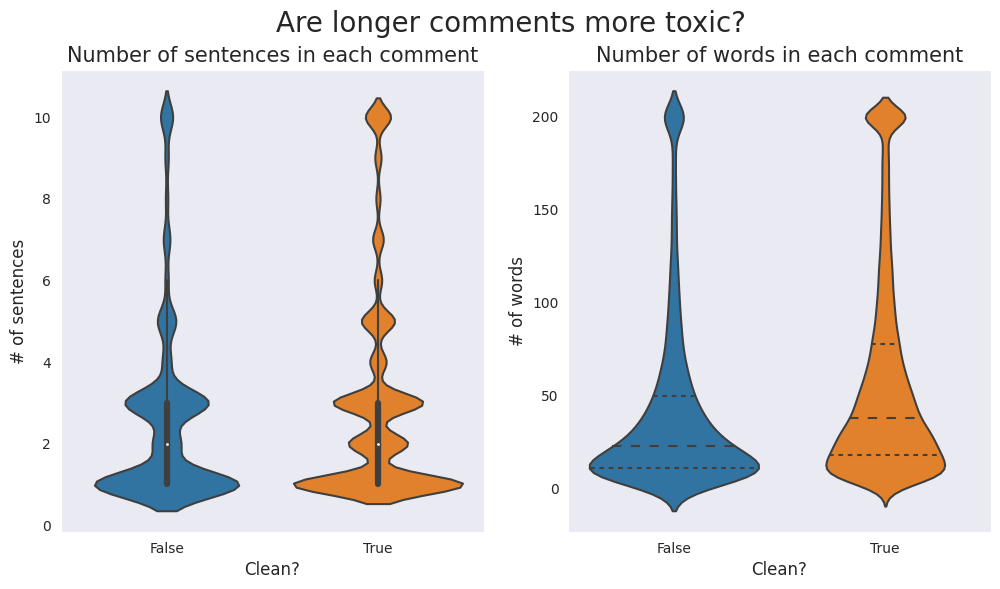

In [ ]:
train_feats['count_sent'].loc[train_feats['count_sent']>10] = 10 
plt.figure(figsize=(12,6))
## sentences
plt.subplot(121)
plt.suptitle("Are longer comments more toxic?",fontsize=20)
sns.violinplot(y='count_sent',x='clean', data=train_feats,split=True)
plt.xlabel('Clean?', fontsize=12)
plt.ylabel('# of sentences', fontsize=12)
plt.title("Number of sentences in each comment", fontsize=15)
# words
train_feats['count_word'].loc[train_feats['count_word']>200] = 200
plt.subplot(122)
sns.violinplot(y='count_word',x='clean', data=train_feats,split=True,inner="quart")
plt.xlabel('Clean?', fontsize=12)
plt.ylabel('# of words', fontsize=12)
plt.title("Number of words in each comment", fontsize=15)

plt.show()

Long sentences or more words do not seem to be a significant indicator of toxicity.

Chart desc: Violin plot is an alternative to the traditional box plot. The inner markings show the percentiles while the width of the "violin" shows the volume of comments at that level/instance.

In [ ]:
pd.melt(train_feats, value_vars=['count_word', 'count_unique_word'], id_vars='clean')

,clean,variable,value
0,True,count_word,43
1,True,count_word,17
2,True,count_word,42
3,True,count_word,113
4,True,count_word,13
...,...,...,...
319137,True,count_unique_word,44
319138,True,count_unique_word,18
319139,True,count_unique_word,12
319140,True,count_unique_word,23


In [ ]:
train_feats['count_unique_word'].loc[train_feats['count_unique_word']>200] = 200
#prep for split violin plots
#For the desired plots , the data must be in long format
temp_df = pd.melt(train_feats, value_vars=['count_word', 'count_unique_word'], id_vars='clean')
#spammers - comments with less than 40% unique words
spammers=train_feats[train_feats['word_unique_percent']<30]

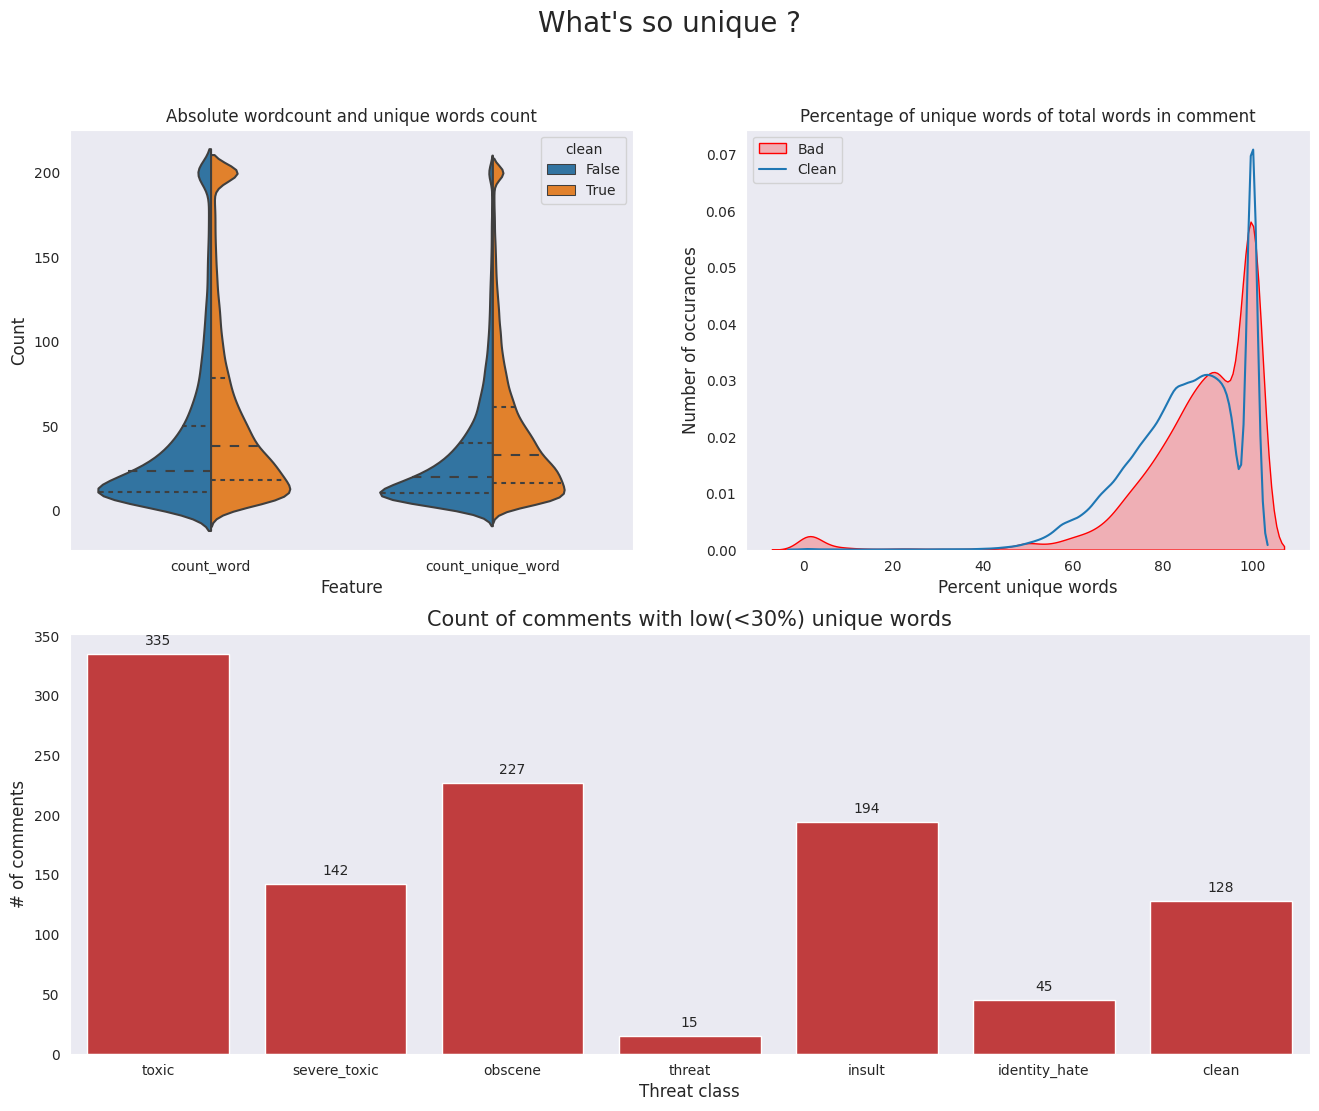

In [ ]:
plt.figure(figsize=(16,12))
plt.suptitle("What's so unique ?",fontsize=20)
gridspec.GridSpec(2,2)
plt.subplot2grid((2,2),(0,0))
sns.violinplot(x='variable', y='value', hue='clean', data=temp_df,split=True,inner='quartile')
plt.title("Absolute wordcount and unique words count")
plt.xlabel('Feature', fontsize=12)
plt.ylabel('Count', fontsize=12)

plt.subplot2grid((2,2),(0,1))
plt.title("Percentage of unique words of total words in comment")
#sns.boxplot(x='clean', y='word_unique_percent', data=train_feats)
ax=sns.kdeplot(train_feats[train_feats.clean == 0].word_unique_percent, label="Bad",shade=True,color='r')
ax=sns.kdeplot(train_feats[train_feats.clean == 1].word_unique_percent, label="Clean")
plt.legend()
plt.ylabel('Number of occurances', fontsize=12)
plt.xlabel('Percent unique words', fontsize=12)

x=spammers.iloc[:,-7:].sum()
plt.subplot2grid((2,2),(1,0),colspan=2)
plt.title("Count of comments with low(<30%) unique words",fontsize=15)
ax=sns.barplot(x=x.index, y=x.values,color=color[3])

#adding the text labels
rects = ax.patches
labels = x.values
for rect, label in zip(rects, labels):
    height = rect.get_height()
    ax.text(rect.get_x() + rect.get_width()/2, height + 5, label, ha='center', va='bottom')

plt.xlabel('Threat class', fontsize=12)
plt.ylabel('# of comments', fontsize=12)
plt.show()

### Word count VS unique word count:
There are noticeable shifts in the mean of both word count and unique word count across clean and toxic comments.
   * Chart desc: The first chart is a split violin chart. It is a variation of the traditional box chart/violin chart which allows us to split the violin in the middle based on a categorical variable.
   
### Unique word count percent:
There is a bulge near the 0-10% mark which indicates a large number of toxic comments which contain very little variety of words.
   * Chart desc: The second chart is an overlay of two kernel density estimation plots of percentage of unique words out of all the words in the comment, done for both clean and toxic comments


# Spammers are more toxic!
No surprises here. Let's take a look at some clean and toxic spam messages

In [ ]:
print("Clean Spam example:")
print(spammers[spammers.clean==1].comment_text.iloc[25])
print("Toxic Spam example:")
print(spammers[spammers.toxic==1].comment_text.iloc[82])

Clean Spam example:
BYE BYE BYE BYE BYE BYE BYE BYE BYE BYE BYE BYE BYE BYE BYE BYE BYE BYE BYE BYE BYE BYE BYE BYE BYE BYE BYE BYE BYE BYE BYE BYE BYE BYE BYE BYE BYE BYE BYE BYE BYE BYE BYE BYE BYE BYE BYE BYE BYE BYE BYE BYE BYE BYE BYE BYE BYE BYE BYE BYE BYE BYE BYE BYE BYE BYE BYE BYE BYE BYE BYE BYE BYE BYE BYE BYE BYE BYE BYE BYE BYE BYE BYE BYE BYE BYE BYE BYE BYE BYE BYE BYE BYE BYE BYE BYE BYE BYE BYE BYE BYE BYE BYE BYE BYE BYE BYE BYE BYE BYE BYE BYE BYE BYE BYE BYE BYE BYE BYE BYE BYE BYE BYE BYE BYE BYE BYE BYE BYE BYE BYE BYE BYE BYE BYE BYE BYE BYE BYE BYE BYE BYE BYE BYE BYE BYE BYE BYE BYE BYE BYE BYE BYE BYE BYE BYE BYE BYE BYE BYE BYE BYE
Toxic Spam example:
Do I know you? ==BeCauSe You aRe a FGGT!
 Do I know you? BeCauSe You aRe a FGGT!
 Do I know you? BeCauSe You aRe a FGGT!
 Do I know you? BeCauSe You aRe a FGGT!
 Do I know you? BeCauSe You aRe a FGGT!
 Do I know you? BeCauSe You aRe a FGGT!
 Do I know you? BeCauSe You aRe a FGGT!
 Do I know you? BeCauSe You aRe

# Spam is toxic to the model too!

These spam entries are bad if we design our model to contain normal word counts features.
Imagine the scenario in which our model picked up the words "mitt romney" from any comment and classified it as toxic :(


# Leaky features
**Caution:** Even-though including these features might help us perform better in this particular scenario, it will not make sense to add them in the final model/general purpose model.

Here we are creating our own custom count vectorizer to create count variables that match our regex condition.


In [ ]:
#Leaky features
df['ip']=df["comment_text"].apply(lambda x: re.findall("\d{1,3}\.\d{1,3}\.\d{1,3}\.\d{1,3}",str(x)))
#count of ip addresses
df['count_ip']=df["ip"].apply(lambda x: len(x))

#links
df['link']=df["comment_text"].apply(lambda x: re.findall("http://.*com",str(x)))
#count of links
df['count_links']=df["link"].apply(lambda x: len(x))

#article ids
df['article_id']=df["comment_text"].apply(lambda x: re.findall("\d:\d\d\s{0,5}$",str(x)))
df['article_id_flag']=df.article_id.apply(lambda x: len(x))

#username
##              regex for     Match anything with [[User: ---------- ]]
# regexp = re.compile("\[\[User:(.*)\|")
df['username']=df["comment_text"].apply(lambda x: re.findall("\[\[User(.*)\|",str(x)))
#count of username mentions
df['count_usernames']=df["username"].apply(lambda x: len(x))
#check if features are created
#df.username[df.count_usernames>0]

# Leaky Ip
cv = CountVectorizer()
count_feats_ip = cv.fit_transform(df["ip"].apply(lambda x : str(x)))


# Leaky usernames

cv = CountVectorizer()
count_feats_user = cv.fit_transform(df["username"].apply(lambda x : str(x)))



In [ ]:
df[df.count_usernames!=0].comment_text.iloc[0]

'2010]]\n[[User talk:Wikireader41/Archive4|Archive 5-Mar 15'

In [ ]:
# check few names
cv.get_feature_names_out()[120:130]

array(['destruction', 'diablo', 'diligent', 'dland', 'dlohcierekim',
       'dodo', 'dominick', 'douglas', 'dpl', 'dr'], dtype=object)

# Leaky Feature Stability:
Checking the re-occurance of leaky features to check their utility in predicting the test set. 




In [ ]:
leaky_feats=df[["ip","link","article_id","username","count_ip","count_links","count_usernames","article_id_flag"]]
leaky_feats_train=leaky_feats.iloc[:train.shape[0]]
leaky_feats_test=leaky_feats.iloc[train.shape[0]:]

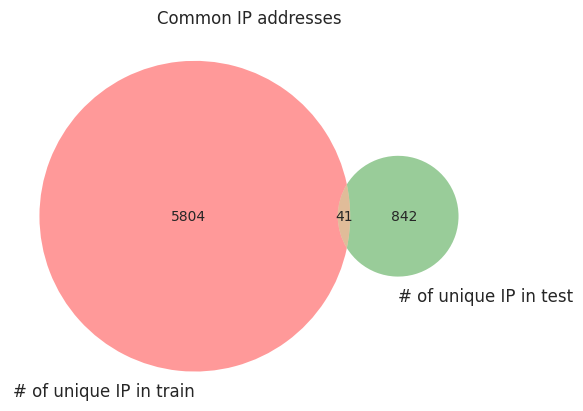

In [ ]:
#filterout the entries without ips
train_ips=leaky_feats_train.ip[leaky_feats_train.count_ip!=0]
test_ips=leaky_feats_test.ip[leaky_feats_test.count_ip!=0]
#get the unique list of ips in test and train datasets
train_ip_list=list(set([a for b in train_ips.tolist() for a in b]))
test_ip_list=list(set([a for b in test_ips.tolist() for a in b]))

# get common elements
common_ip_list=list(set(train_ip_list).intersection(test_ip_list))
plt.title("Common IP addresses")
venn.venn2(subsets=(len(train_ip_list),len(test_ip_list),len(common_ip_list)),set_labels=("# of unique IP in train","# of unique IP in test"))
plt.show()

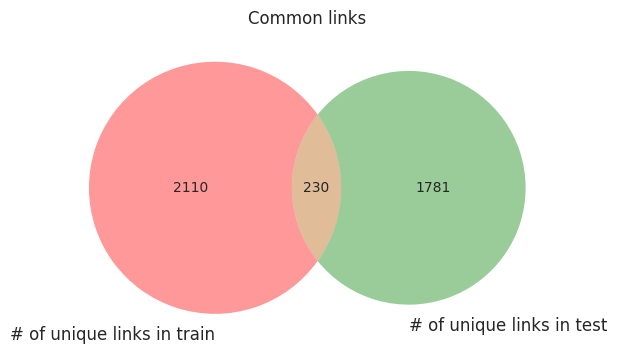

In [ ]:
#filterout the entries without links
train_links=leaky_feats_train.link[leaky_feats_train.count_links!=0]
test_links=leaky_feats_test.link[leaky_feats_test.count_links!=0]
#get the unique list of ips in test and train datasets
train_links_list=list(set([a for b in train_links.tolist() for a in b]))
test_links_list=list(set([a for b in test_links.tolist() for a in b]))

# get common elements
common_links_list=list(set(train_links_list).intersection(test_links_list))
plt.title("Common links")
venn.venn2(subsets=(len(train_links_list),len(test_links_list),len(common_links_list)),
           set_labels=("# of unique links in train","# of unique links in test"))
plt.show()

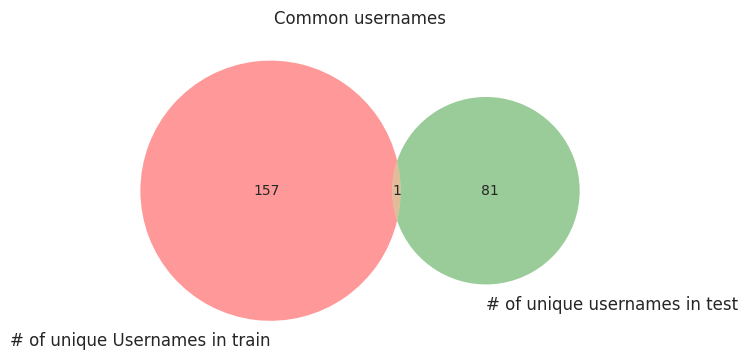

In [ ]:
#filterout the entries without users
train_users=leaky_feats_train.username[leaky_feats_train.count_usernames!=0]
test_users=leaky_feats_test.username[leaky_feats_test.count_usernames!=0]
#get the unique list of ips in test and train datasets
train_users_list=list(set([a for b in train_users.tolist() for a in b]))
test_users_list=list(set([a for b in test_users.tolist() for a in b]))

# get common elements
common_users_list=list(set(train_users_list).intersection(test_users_list))
plt.title("Common usernames")
venn.venn2(subsets=(len(train_users_list),len(test_users_list),len(common_users_list)),
           set_labels=("# of unique Usernames in train","# of unique usernames in test"))
plt.show()

The feature stability (aka) the reoccurance of train dataset usernames in the test dataset seems to be minimal. 
We can just use the intersection (eg) the common IPs/links for test and train in our feature engineering.

Another usecase for the list of IPs would be to find out if they are a part of the [blocked IP list](https://en.wikipedia.org/wiki/Wikipedia:Database_reports/Indefinitely_blocked_IPs)

# Corpus cleaning:

Its important to use a clean dataset before creating count features. 

In [ ]:
corpus=merge.comment_text

In [ ]:
#https://drive.google.com/file/d/0B1yuv8YaUVlZZ1RzMFJmc1ZsQmM/view
# Aphost lookup dict
APPO = {
"aren't" : "are not",
"can't" : "cannot",
"couldn't" : "could not",
"didn't" : "did not",
"doesn't" : "does not",
"don't" : "do not",
"hadn't" : "had not",
"hasn't" : "has not",
"haven't" : "have not",
"he'd" : "he would",
"he'll" : "he will",
"he's" : "he is",
"i'd" : "I would",
"i'd" : "I had",
"i'll" : "I will",
"i'm" : "I am",
"isn't" : "is not",
"it's" : "it is",
"it'll":"it will",
"i've" : "I have",
"let's" : "let us",
"mightn't" : "might not",
"mustn't" : "must not",
"shan't" : "shall not",
"she'd" : "she would",
"she'll" : "she will",
"she's" : "she is",
"shouldn't" : "should not",
"that's" : "that is",
"there's" : "there is",
"they'd" : "they would",
"they'll" : "they will",
"they're" : "they are",
"they've" : "they have",
"we'd" : "we would",
"we're" : "we are",
"weren't" : "were not",
"we've" : "we have",
"what'll" : "what will",
"what're" : "what are",
"what's" : "what is",
"what've" : "what have",
"where's" : "where is",
"who'd" : "who would",
"who'll" : "who will",
"who're" : "who are",
"who's" : "who is",
"who've" : "who have",
"won't" : "will not",
"wouldn't" : "would not",
"you'd" : "you would",
"you'll" : "you will",
"you're" : "you are",
"you've" : "you have",
"'re": " are",
"wasn't": "was not",
"we'll":" will",
"didn't": "did not",
"tryin'":"trying"
}

In [ ]:
nltk.download('wordnet')

[nltk_data] Downloading package wordnet to /root/nltk_data...


True

In [ ]:
def clean(comment):
    """
    This function receives comments and returns clean word-list
    """
    #Convert to lower case , so that Hi and hi are the same
    comment=comment.lower()
    #remove \n
    comment=re.sub("\\n","",comment)
    # remove leaky elements like ip,user
    comment=re.sub("\d{1,3}\.\d{1,3}\.\d{1,3}\.\d{1,3}","",comment)
    #removing usernames
    comment=re.sub("\[\[.*\]","",comment)
    
    #Split the sentences into words
    words=tokenizer.tokenize(comment)
    
    # (')aphostophe  replacement (ie)   you're --> you are  
    # ( basic dictionary lookup : master dictionary present in a hidden block of code)
    words=[APPO[word] if word in APPO else word for word in words]
    words=[lem.lemmatize(word, "v") for word in words]
    words = [w for w in words if not w in eng_stopwords]
    
    clean_sent=" ".join(words)
    # remove any non alphanum,digit character
    #clean_sent=re.sub("\W+"," ",clean_sent)
    #clean_sent=re.sub("  "," ",clean_sent)
    return(clean_sent)

see re cheatsheet

In [ ]:
corpus.iloc[39]

"Notability of Rurika Kasuga\nA tag has been placed on Rurika Kasuga, requesting that it be speedily deleted from Wikipedia. This has been done because the article seems to be about a person, group of people, band, club, company, or web content, but it does not indicate how or why the subject is notable, that is, why an article about that subject should be included in Wikipedia. Under the criteria for speedy deletion, articles that do not assert notability may be deleted at any time. Please see the guidelines for what is generally accepted as notable, and if you can indicate why the subject of this article is notable, you may contest the tagging. To do this, add  on the top of the page (below the existing db tag) and leave a note on the article's talk page explaining your position. Please do not remove the speedy deletion tag yourself, but don't hesitate to add information to the article that would confirm its subject's notability under the guidelines.\n\nFor guidelines on specific typ

In [ ]:
clean(corpus.iloc[35])

'" , make straw man argument . never claim o\'donohue position , rather practitioners researchers field ignore dsm position , exactly quote say also something o\'donohue agree . , combat notion " " absurd part " " claim pedophilia sexual orientation . since many researchers hold position , would unfair call absurd . disorder part divide field , argue disorder , . end day , value judgment ( cantor point earlier thread ) , scientific judgement . choose make value judgment article , state clearly pretend scientific basis . "'

In [ ]:
clean_corpus=corpus.apply(lambda x :clean(x))

end_time=time.time()
print("total time till Cleaning",end_time-start_time)

total time till Cleaning 5158.0839195251465


# Direct features:

## 1)Count based features(for unigrams):
Lets create some features based on frequency distribution of the words. Initially lets consider taking words one at a time (ie) Unigrams

Python's SKlearn provides 3 ways of creating count features.All three of them first create a vocabulary(dictionary) of words and then create a [sparse matrix](#https://en.wikipedia.org/wiki/Sparse_matrix) of word counts for the words in the sentence that are present in the dictionary. A brief description of them:
* CountVectorizer
    * Creates a matrix with frequency counts of each word in the text corpus
* TF-IDF Vectorizer
    * TF - Term Frequency -- Count of the words(Terms) in the text corpus (same of Count Vect)
    * IDF - Inverse Document Frequency -- Penalizes words that are too frequent. We can think of this as regularization
 
        
Using TF-IDF here.
Note: Using the concatenated dataframe "merge" which contains both text from train and test dataset to ensure that the vocabulary that we create does not missout on the words that are unique to testset.

In [ ]:
### Unigrams -- TF-IDF 
# using settings recommended here for TF-IDF -- https://www.kaggle.com/abhishek/approaching-almost-any-nlp-problem-on-kaggle

#some detailed description of the parameters
# min_df=10 --- ignore terms that appear lesser than 10 times 
# max_features=None  --- Create as many words as present in the text corpus
    # changing max_features to 10k for memmory issues
# analyzer='word'  --- Create features from words (alternatively char can also be used)
# ngram_range=(1,1)  --- Use only one word at a time (unigrams)
# strip_accents='unicode' -- removes accents
# use_idf=1,smooth_idf=1 --- enable IDF
# sublinear_tf=1   --- Apply sublinear tf scaling, i.e. replace tf with 1 + log(tf)


#temp settings to min=200 to facilitate top features section to run in kernals
#change back to min=10 to get better results
start_unigrams=time.time()
tfv = TfidfVectorizer(min_df=200,  max_features=10000, 
            strip_accents='unicode', analyzer='word',ngram_range=(1,1),
            use_idf=1,smooth_idf=1,sublinear_tf=1,
            stop_words = 'english')
tfv.fit(clean_corpus)
features = np.array(tfv.get_feature_names_out())

train_unigrams =  tfv.transform(clean_corpus.iloc[:train.shape[0]])
test_unigrams = tfv.transform(clean_corpus.iloc[train.shape[0]:])

In [ ]:
#print(train_unigrams)


In [ ]:
#https://buhrmann.github.io/tfidf-analysis.html
def top_tfidf_feats(row, features, top_n=25):
    ''' Get top n tfidf values in row and return them with their corresponding feature names.'''
    topn_ids = np.argsort(row)[::-1][:top_n]
    top_feats = [(features[i], row[i]) for i in topn_ids]
    df = pd.DataFrame(top_feats)
    df.columns = ['feature', 'tfidf']
    return df

def top_feats_in_doc(Xtr, features, row_id, top_n=25):
    ''' Top tfidf features in specific document (matrix row) '''
    row = np.squeeze(Xtr[row_id].toarray())
    return top_tfidf_feats(row, features, top_n)

def top_mean_feats(Xtr, features, grp_ids, min_tfidf=0.1, top_n=25):
    ''' Return the top n features that on average are most important amongst documents in rows
        indentified by indices in grp_ids. '''
    
    D = Xtr[grp_ids].toarray()

    D[D < min_tfidf] = 0
    tfidf_means = np.mean(D, axis=0)
    return top_tfidf_feats(tfidf_means, features, top_n)

# modified for multilabel milticlass
def top_feats_by_class(Xtr, features, min_tfidf=0.1, top_n=20):
    ''' Return a list of dfs, where each df holds top_n features and their mean tfidf value
        calculated across documents with the same class label. '''
    dfs = []
    cols=train_tags.columns
    for col in cols:
        ids = train_tags.index[train_tags[col]==1]
        feats_df = top_mean_feats(Xtr, features, ids, min_tfidf=min_tfidf, top_n=top_n)
        feats_df.label = label
        dfs.append(feats_df)
    return dfs

In [ ]:
#get top n for unigrams
tfidf_top_n_per_lass=top_feats_by_class(train_unigrams,features)

end_unigrams=time.time()

print("total time in unigrams",end_unigrams-start_unigrams)
print("total time till unigrams",end_unigrams-start_time)


total time in unigrams 28.54740285873413
total time till unigrams 5246.35821723938


In [ ]:
tfidf_top_n_per_lass.head()

AttributeError: ignored

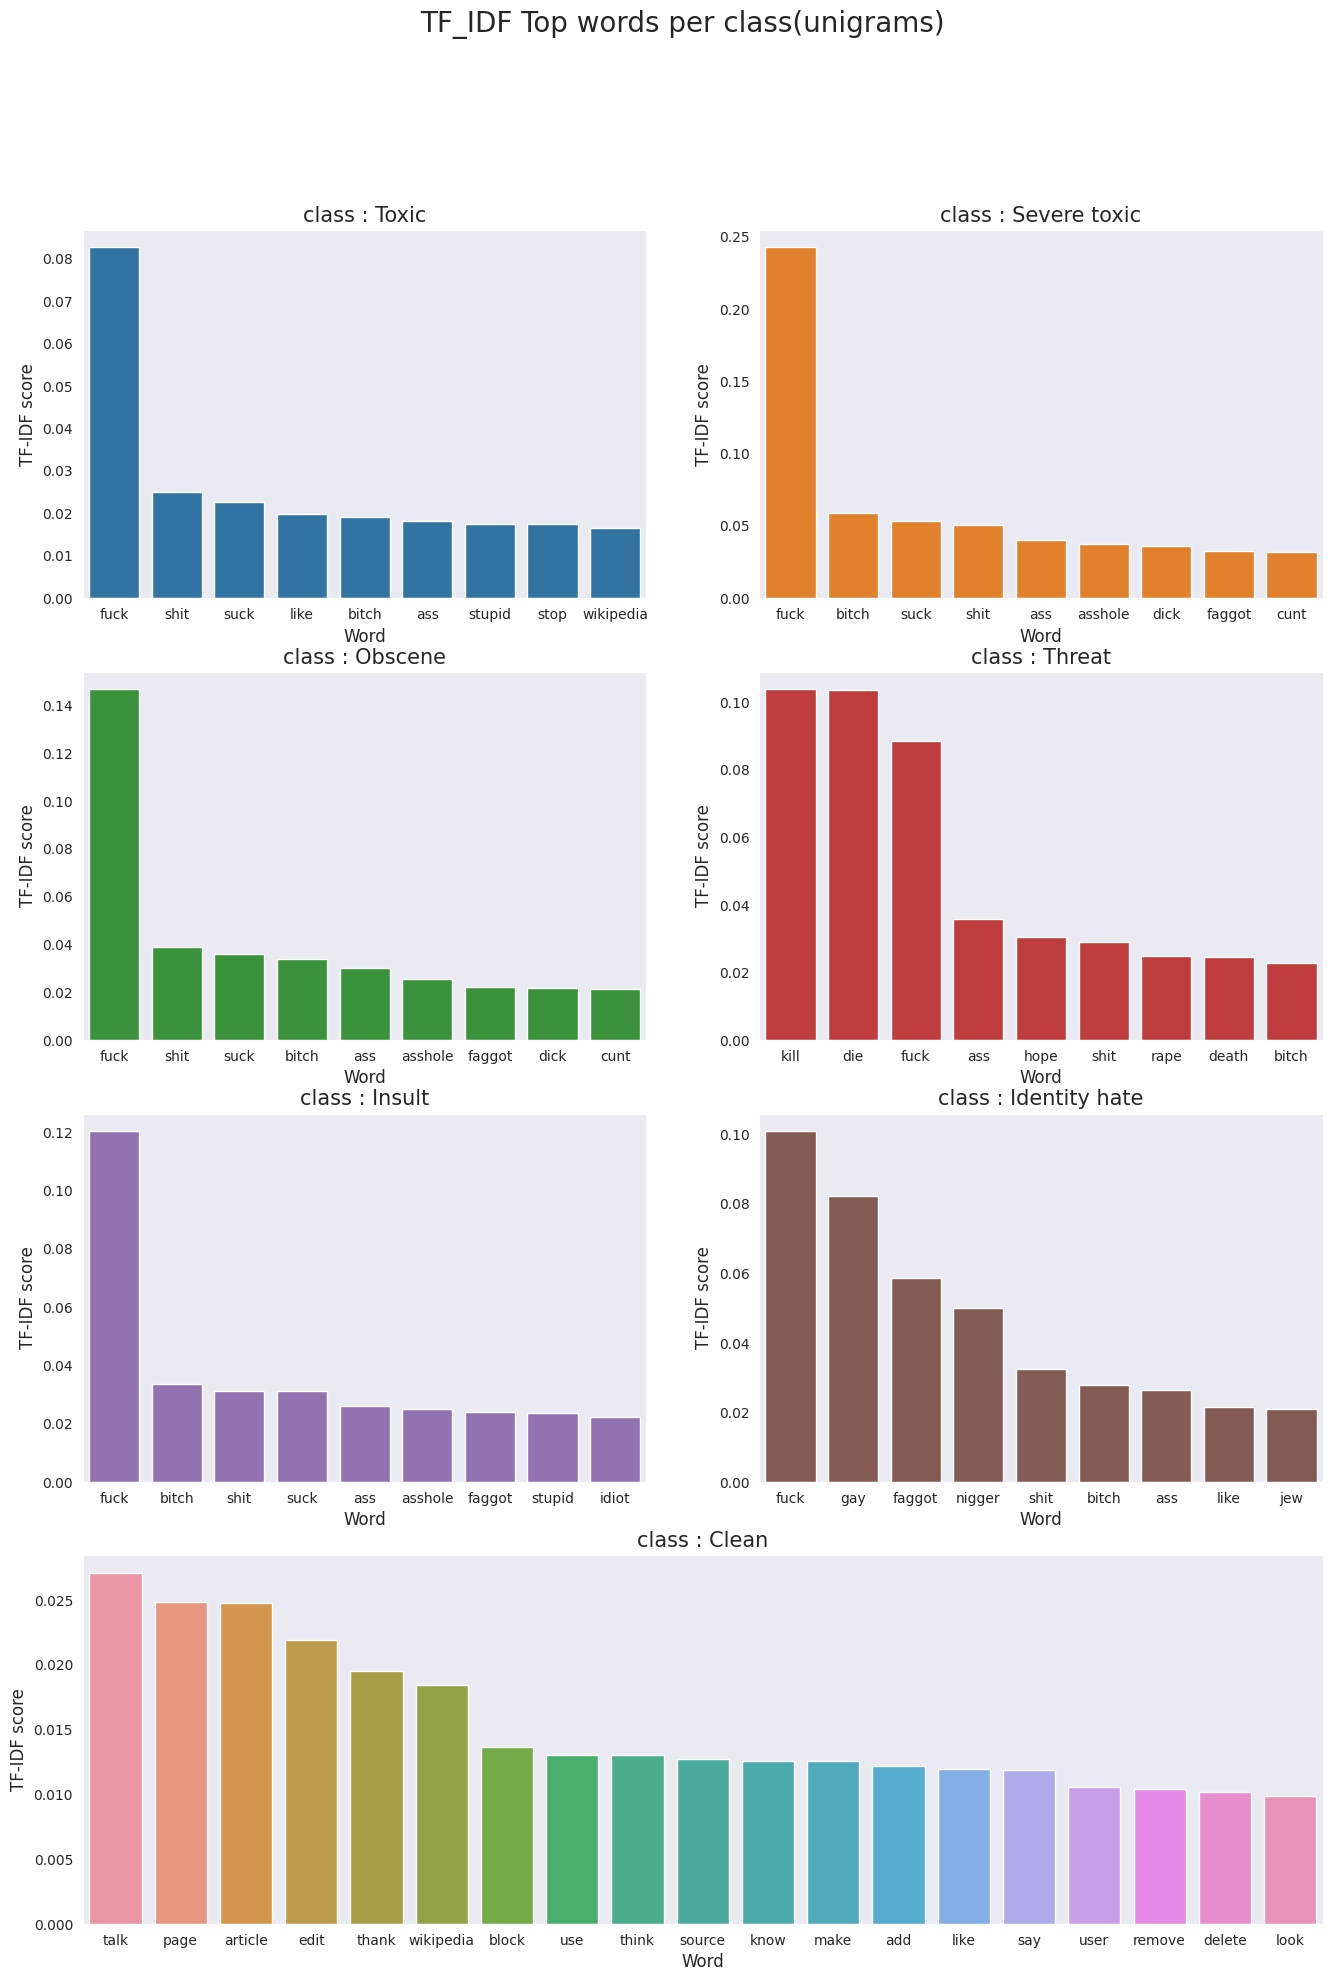

In [ ]:
plt.figure(figsize=(16,22))
plt.suptitle("TF_IDF Top words per class(unigrams)",fontsize=20)
gridspec.GridSpec(4,2)
plt.subplot2grid((4,2),(0,0))
sns.barplot(x=tfidf_top_n_per_lass[0].feature.iloc[0:9],y=tfidf_top_n_per_lass[0].tfidf.iloc[0:9],color=color[0])
plt.title("class : Toxic",fontsize=15)
plt.xlabel('Word', fontsize=12)
plt.ylabel('TF-IDF score', fontsize=12)

plt.subplot2grid((4,2),(0,1))
sns.barplot(x=tfidf_top_n_per_lass[1].feature.iloc[0:9],y=tfidf_top_n_per_lass[1].tfidf.iloc[0:9],color=color[1])
plt.title("class : Severe toxic",fontsize=15)
plt.xlabel('Word', fontsize=12)
plt.ylabel('TF-IDF score', fontsize=12)


plt.subplot2grid((4,2),(1,0))
sns.barplot(x=tfidf_top_n_per_lass[2].feature.iloc[0:9],y=tfidf_top_n_per_lass[2].tfidf.iloc[0:9],color=color[2])
plt.title("class : Obscene",fontsize=15)
plt.xlabel('Word', fontsize=12)
plt.ylabel('TF-IDF score', fontsize=12)


plt.subplot2grid((4,2),(1,1))
sns.barplot(x=tfidf_top_n_per_lass[3].feature.iloc[0:9],y=tfidf_top_n_per_lass[3].tfidf.iloc[0:9],color=color[3])
plt.title("class : Threat",fontsize=15)
plt.xlabel('Word', fontsize=12)
plt.ylabel('TF-IDF score', fontsize=12)


plt.subplot2grid((4,2),(2,0))
sns.barplot(x=tfidf_top_n_per_lass[4].feature.iloc[0:9],y=tfidf_top_n_per_lass[4].tfidf.iloc[0:9],color=color[4])
plt.title("class : Insult",fontsize=15)
plt.xlabel('Word', fontsize=12)
plt.ylabel('TF-IDF score', fontsize=12)


plt.subplot2grid((4,2),(2,1))
sns.barplot(x=tfidf_top_n_per_lass[5].feature.iloc[0:9],y=tfidf_top_n_per_lass[5].tfidf.iloc[0:9],color=color[5])
plt.title("class : Identity hate",fontsize=15)
plt.xlabel('Word', fontsize=12)
plt.ylabel('TF-IDF score', fontsize=12)


plt.subplot2grid((4,2),(3,0),colspan=2)
sns.barplot(x=tfidf_top_n_per_lass[6].feature.iloc[0:19],y=tfidf_top_n_per_lass[6].tfidf.iloc[0:19])
plt.title("class : Clean",fontsize=15)
plt.xlabel('Word', fontsize=12)
plt.ylabel('TF-IDF score', fontsize=12)

plt.show()

In [ ]:

#temp settings to min=150 to facilitate top features section to run in kernals
#change back to min=10 to get better results
tfv = TfidfVectorizer(min_df=150,  max_features=30000, 
            strip_accents='unicode', analyzer='word',ngram_range=(2,2),
            use_idf=1,smooth_idf=1,sublinear_tf=1,
            stop_words = 'english')

tfv.fit(clean_corpus)
features = np.array(tfv.get_feature_names_out())
train_bigrams =  tfv.transform(clean_corpus.iloc[:train.shape[0]])
test_bigrams = tfv.transform(clean_corpus.iloc[train.shape[0]:])
#get top n for bigrams
tfidf_top_n_per_lass=top_feats_by_class(train_bigrams,features)

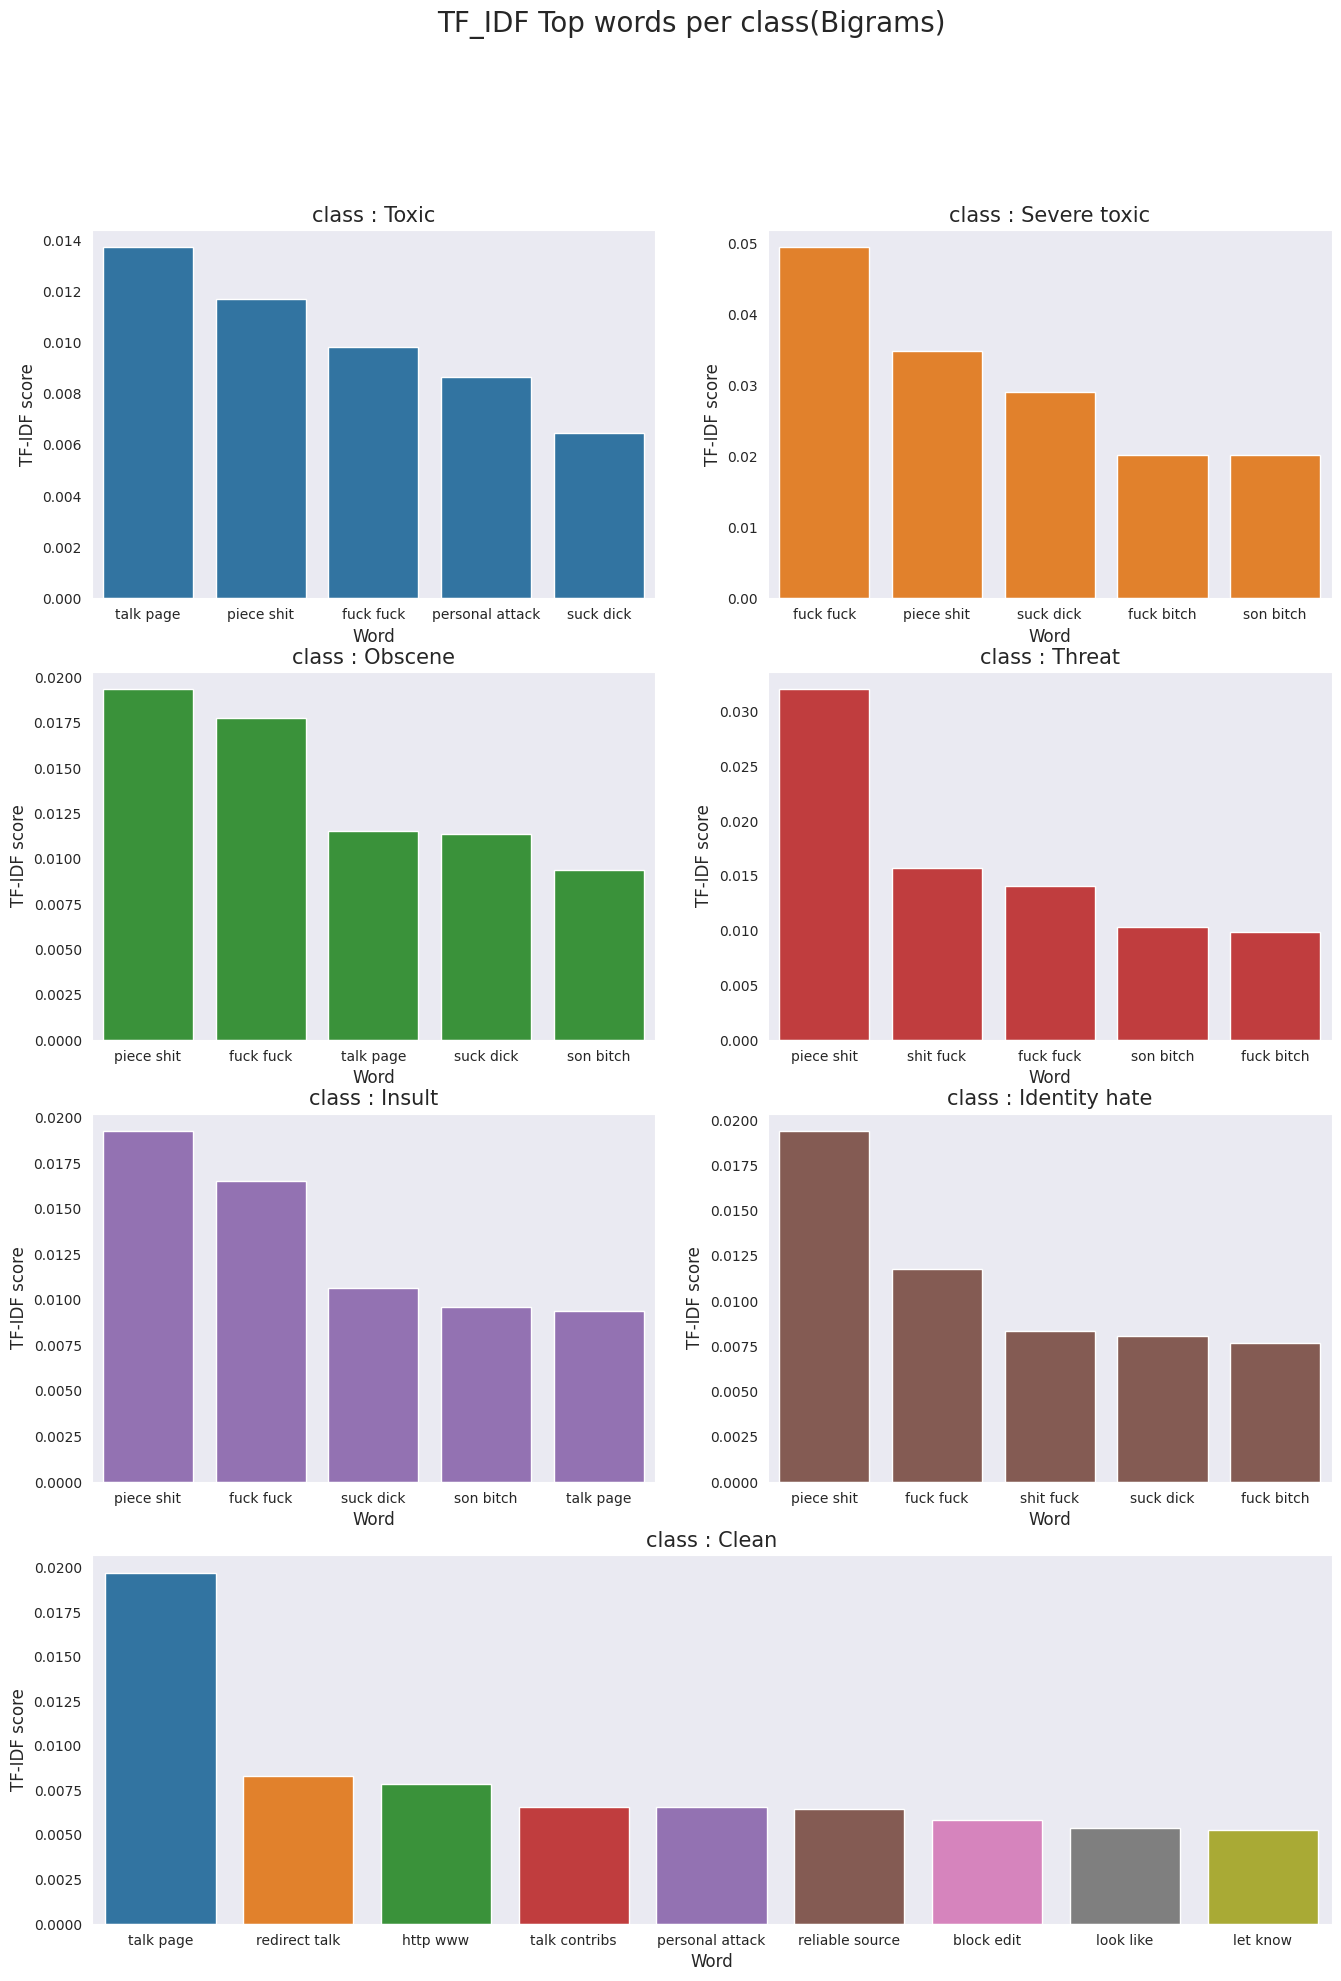

In [ ]:
plt.figure(figsize=(16,22))
plt.suptitle("TF_IDF Top words per class(Bigrams)",fontsize=20)
gridspec.GridSpec(4,2)
plt.subplot2grid((4,2),(0,0))
sns.barplot(x=tfidf_top_n_per_lass[0].feature.iloc[0:5],y=tfidf_top_n_per_lass[0].tfidf.iloc[0:5],color=color[0])
plt.title("class : Toxic",fontsize=15)
plt.xlabel('Word', fontsize=12)
plt.ylabel('TF-IDF score', fontsize=12)

plt.subplot2grid((4,2),(0,1))
sns.barplot(x=tfidf_top_n_per_lass[1].feature.iloc[0:5],y=tfidf_top_n_per_lass[1].tfidf.iloc[0:5],color=color[1])
plt.title("class : Severe toxic",fontsize=15)
plt.xlabel('Word', fontsize=12)
plt.ylabel('TF-IDF score', fontsize=12)


plt.subplot2grid((4,2),(1,0))
sns.barplot(x=tfidf_top_n_per_lass[2].feature.iloc[0:5],y=tfidf_top_n_per_lass[2].tfidf.iloc[0:5],color=color[2])
plt.title("class : Obscene",fontsize=15)
plt.xlabel('Word', fontsize=12)
plt.ylabel('TF-IDF score', fontsize=12)


plt.subplot2grid((4,2),(1,1))
sns.barplot(x=tfidf_top_n_per_lass[3].feature.iloc[0:5],y=tfidf_top_n_per_lass[3].tfidf.iloc[0:5],color=color[3])
plt.title("class : Threat",fontsize=15)
plt.xlabel('Word', fontsize=12)
plt.ylabel('TF-IDF score', fontsize=12)


plt.subplot2grid((4,2),(2,0))
sns.barplot(x=tfidf_top_n_per_lass[4].feature.iloc[0:5],y=tfidf_top_n_per_lass[4].tfidf.iloc[0:5],color=color[4])
plt.title("class : Insult",fontsize=15)
plt.xlabel('Word', fontsize=12)
plt.ylabel('TF-IDF score', fontsize=12)


plt.subplot2grid((4,2),(2,1))
sns.barplot(x=tfidf_top_n_per_lass[5].feature.iloc[0:5],y=tfidf_top_n_per_lass[5].tfidf.iloc[0:5],color=color[5])
plt.title("class : Identity hate",fontsize=15)
plt.xlabel('Word', fontsize=12)
plt.ylabel('TF-IDF score', fontsize=12)


plt.subplot2grid((4,2),(3,0),colspan=2)
sns.barplot(x=tfidf_top_n_per_lass[6].feature.iloc[0:9],y=tfidf_top_n_per_lass[6].tfidf.iloc[0:9])
plt.title("class : Clean",fontsize=15)
plt.xlabel('Word', fontsize=12)
plt.ylabel('TF-IDF score', fontsize=12)

plt.show()

In [ ]:
end_time=time.time()
print("total time till bigrams",end_time-start_time)

total time till bigrams 5351.423500061035


In [ ]:
tfv = TfidfVectorizer(min_df=100,  max_features=30000, 
            strip_accents='unicode', analyzer='char',ngram_range=(1,4),
            use_idf=1,smooth_idf=1,sublinear_tf=1,
            stop_words = 'english')

tfv.fit(clean_corpus)
#features = np.array(tfv.get_feature_names_out())
#train_charngrams =  tfv.transform(clean_corpus.iloc[:train.shape[0]])
#test_charngrams = tfv.transform(clean_corpus.iloc[train.shape[0]:])
#end_time=time.time()
print("total time till charngrams",end_time-start_time)

total time till charngrams 5351.423500061035


# Baseline Model:

In [ ]:
#Credis to AlexSanchez https://www.kaggle.com/jhoward/nb-svm-strong-linear-baseline-eda-0-052-lb#261316
#custom NB model

class NbSvmClassifier(BaseEstimator, ClassifierMixin):
    def __init__(self, C=1.0, dual=False, n_jobs=1):
        self.C = C
        self.dual = dual
        self.n_jobs = n_jobs

    def predict(self, x):
        # Verify that model has been fit
        check_is_fitted(self, ['_r', '_clf'])
        return self._clf.predict(x.multiply(self._r))

    def predict_proba(self, x):
        # Verify that model has been fit
        check_is_fitted(self, ['_r', '_clf'])
        return self._clf.predict_proba(x.multiply(self._r))

    def fit(self, x, y):
        # Check that X and y have correct shape
        y = y.values
        x, y = check_X_y(x, y, accept_sparse=True)

        def pr(x, y_i, y):
            p = x[y==y_i].sum(0)
            return (p+1) / ((y==y_i).sum()+1)

        self._r = sparse.csr_matrix(np.log(pr(x,1,y) / pr(x,0,y)))
        x_nb = x.multiply(self._r)
        self._clf = LogisticRegression(C=self.C, dual=self.dual, n_jobs=self.n_jobs).fit(x_nb, y)
        return self
    
# model = NbSvmClassifier(C=4, dual=True, n_jobs=-1)


In [ ]:
SELECTED_COLS=['count_sent', 'count_word', 'count_unique_word',
       'count_letters', 'count_punctuations', 'count_words_upper',
       'count_words_title', 'count_stopwords', 'mean_word_len',
       'word_unique_percent', 'punct_percent']
target_x=train_feats[SELECTED_COLS]
# target_x

TARGET_COLS=['toxic', 'severe_toxic', 'obscene', 'threat', 'insult', 'identity_hate']
target_y=train_tags[TARGET_COLS]

# Strat k fold due to imbalanced classes
# split = StratifiedKFold(n_splits=2, random_state=1)

#https://www.kaggle.com/yekenot/toxic-regression

In [ ]:
#Just the indirect features -- meta features
print("Using only Indirect features")
model = LogisticRegression(C=3)
X_train, X_valid, y_train, y_valid = train_test_split(target_x, target_y, test_size=0.33, random_state=2018)
train_loss = []
valid_loss = []
importance=[]
preds_train = np.zeros((X_train.shape[0], len(y_train)))
preds_valid = np.zeros((X_valid.shape[0], len(y_valid)))
for i, j in enumerate(TARGET_COLS):
    print('Class:= '+j)
    model.fit(X_train,y_train[j])
    preds_valid[:,i] = model.predict_proba(X_valid)[:,1]
    preds_train[:,i] = model.predict_proba(X_train)[:,1]
    train_loss_class=log_loss(y_train[j],preds_train[:,i])
    valid_loss_class=log_loss(y_valid[j],preds_valid[:,i])
    print('Trainloss=log loss:', train_loss_class)
    print('Validloss=log loss:', valid_loss_class)
    importance.append(model.coef_)
    train_loss.append(train_loss_class)
    valid_loss.append(valid_loss_class)
print('mean column-wise log loss:Train dataset', np.mean(train_loss))
print('mean column-wise log loss:Validation dataset', np.mean(valid_loss))

end_time=time.time()
print("total time till Indirect feat model",end_time-start_time)

Using only Indirect features
Class:= toxic
Trainloss=log loss: 0.30216481633485287
Validloss=log loss: 0.3011736939166855
Class:= severe_toxic
Trainloss=log loss: 0.05063333504150086
Validloss=log loss: 0.05178541603804139
Class:= obscene
Trainloss=log loss: 0.2006508203125949
Validloss=log loss: 0.19907674253461868
Class:= threat
Trainloss=log loss: 0.019805761857256958
Validloss=log loss: 0.01931040993954184
Class:= insult
Trainloss=log loss: 0.1895364861814611
Validloss=log loss: 0.19052059144731806
Class:= identity_hate
Trainloss=log loss: 0.04846514455878685
Validloss=log loss: 0.05162486408938066
mean column-wise log loss:Train dataset 0.13520939404774224
mean column-wise log loss:Validation dataset 0.13558195299426434
total time till Indirect feat model 5509.193563938141


In [ ]:
importance[0][0]

array([ 3.08841577e-02, -4.85078923e-03, -1.80854239e-02,  2.07196375e-04,
        1.38418359e-03,  4.99436280e-02, -1.83276810e-02,  3.94810958e-03,
       -2.24278850e-03, -1.80670676e-02, -2.08188615e-05])

TypeError: ignored

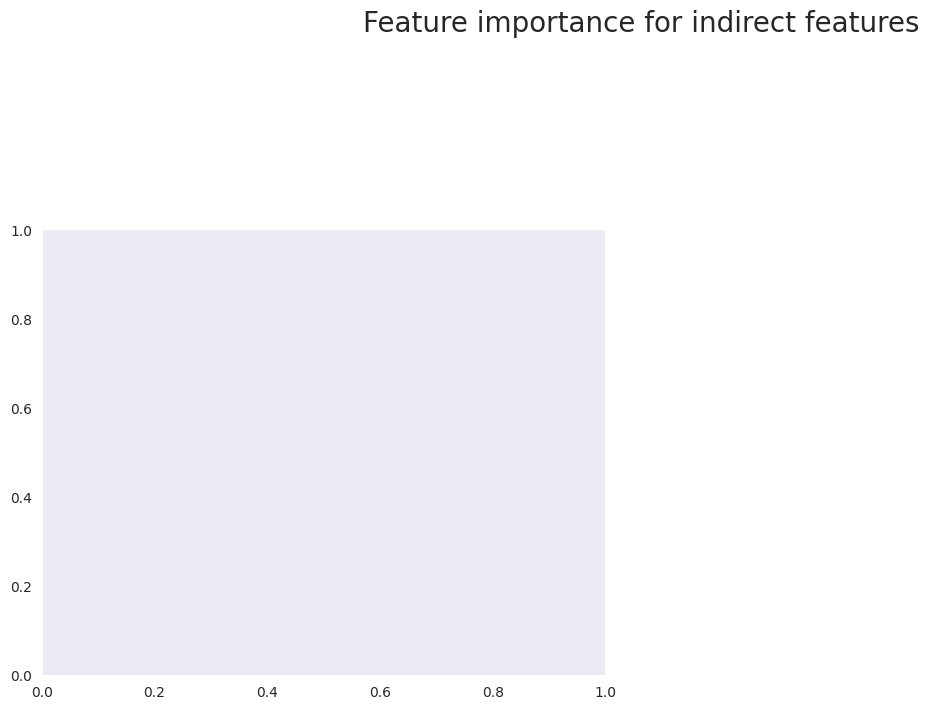

In [ ]:
plt.figure(figsize=(16,22))
plt.suptitle("Feature importance for indirect features",fontsize=20)
gridspec.GridSpec(3,2)
plt.subplots_adjust(hspace=0.4)
plt.subplot2grid((3,2),(0,0))
sns.barplot(SELECTED_COLS,importance[0][0],color=color[0])
plt.title("class : Toxic",fontsize=15)
locs, labels = plt.xticks()
plt.setp(labels, rotation=45)
plt.xlabel('Feature', fontsize=12)
plt.ylabel('Importance', fontsize=12)

plt.subplot2grid((3,2),(0,1))
sns.barplot(SELECTED_COLS,importance[1][0],color=color[1])
plt.title("class : Severe toxic",fontsize=15)
locs, labels = plt.xticks()
plt.setp(labels, rotation=45)
plt.xlabel('Feature', fontsize=12)
plt.ylabel('Importance', fontsize=12)

plt.subplot2grid((3,2),(1,0))
sns.barplot(SELECTED_COLS,importance[2][0],color=color[2])
plt.title("class : Obscene",fontsize=15)
locs, labels = plt.xticks()
plt.setp(labels, rotation=45)
plt.xlabel('Feature', fontsize=12)
plt.ylabel('Importance', fontsize=12)



plt.subplot2grid((3,2),(1,1))
sns.barplot(SELECTED_COLS,importance[3][0],color=color[3])
plt.title("class : Threat",fontsize=15)
locs, labels = plt.xticks()
plt.setp(labels, rotation=45)
plt.xlabel('Feature', fontsize=12)
plt.ylabel('Importance', fontsize=12)


plt.subplot2grid((3,2),(2,0))
sns.barplot(SELECTED_COLS,importance[4][0],color=color[4])
plt.title("class : Insult",fontsize=15)
locs, labels = plt.xticks()
plt.setp(labels, rotation=45)
plt.xlabel('Feature', fontsize=12)
plt.ylabel('Importance', fontsize=12)


plt.subplot2grid((3,2),(2,1))
sns.barplot(SELECTED_COLS,importance[5][0],color=color[5])
plt.title("class : Identity hate",fontsize=15)
locs, labels = plt.xticks()
plt.setp(labels, rotation=45)
plt.xlabel('Feature', fontsize=12)
plt.ylabel('Importance', fontsize=12)


# plt.subplot2grid((4,2),(3,0),colspan=2)
# sns.barplot(SELECTED_COLS,importance[6][0],color=color[0])
# plt.title("class : Clean",fontsize=15)
# locs, labels = plt.xticks()
# plt.setp(labels, rotation=90)
# plt.xlabel('Feature', fontsize=12)
# plt.ylabel('Importance', fontsize=12)

plt.show()

In [ ]:
from scipy.sparse import csr_matrix, hstack

#Using all direct features
print("Using all features except leaky ones")
target_x = hstack((train_bigrams,train_charngrams,train_unigrams,train_feats[SELECTED_COLS])).tocsr()


end_time=time.time()
print("total time till Sparse mat creation",end_time-start_time)

In [ ]:
model = NbSvmClassifier(C=4, dual=True, n_jobs=-1)
X_train, X_valid, y_train, y_valid = train_test_split(target_x, target_y, test_size=0.33, random_state=2018)
train_loss = []
valid_loss = []
preds_train = np.zeros((X_train.shape[0], len(y_train)))
preds_valid = np.zeros((X_valid.shape[0], len(y_valid)))
for i, j in enumerate(TARGET_COLS):
    print('Class:= '+j)
    model.fit(X_train,y_train[j])
    preds_valid[:,i] = model.predict_proba(X_valid)[:,1]
    preds_train[:,i] = model.predict_proba(X_train)[:,1]
    train_loss_class=log_loss(y_train[j],preds_train[:,i])
    valid_loss_class=log_loss(y_valid[j],preds_valid[:,i])
    print('Trainloss=log loss:', train_loss_class)
    print('Validloss=log loss:', valid_loss_class)
    train_loss.append(train_loss_class)
    valid_loss.append(valid_loss_class)
print('mean column-wise log loss:Train dataset', np.mean(train_loss))
print('mean column-wise log loss:Validation dataset', np.mean(valid_loss))


end_time=time.time()
print("total time till NB base model creation",end_time-start_time)

In [ ]:
#Task 1 solution
print("Check for missing values in Train dataset")
null_check=train.isnull().sum()
print(null_check)
print("Check for missing values in Test dataset")
null_check=test.isnull().sum()
print(null_check)
print("filling NA with \"unknown\"")
train["comment_text"].fillna("unknown", inplace=True)
test["comment_text"].fillna("unknown", inplace=True)

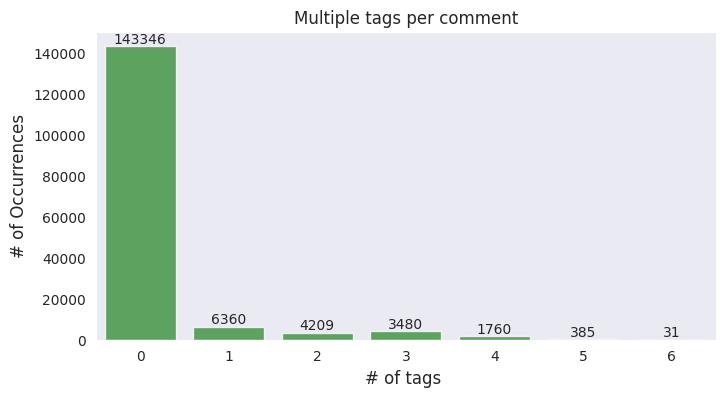

In [ ]:
#task 2 multitagging
x=rowsums.value_counts()

#plot
plt.figure(figsize=(8,4))
ax = sns.barplot(x = x.index, y = x.values, alpha=0.8,color=color[2])
plt.title("Multiple tags per comment")
plt.ylabel('# of Occurrences', fontsize=12)
plt.xlabel('# of tags ', fontsize=12)

#adding the text labels
rects = ax.patches
labels = x.values
for rect, label in zip(rects, labels):
    height = rect.get_height()
    ax.text(rect.get_x() + rect.get_width()/2, height + 5, label, ha='center', va='bottom')

plt.show()

In [ ]:
#task 3

#insult
plt.subplot(224)
insult_mask=np.array(Image.open("../input/imagesforkernal/swords.png"))
insult_mask=insult_mask[:,:,1]
subset=train[train.insult==1]
text=subset.comment_text.values
wc= WordCloud(background_color="black",max_words=2000,mask=insult_mask,stopwords=stopword)
wc.generate(" ".join(text))
plt.axis("off")
plt.title("Words frequented in insult Comments", fontsize=20)
plt.imshow(wc.recolor(colormap= 'Paired_r' , random_state=244), alpha=0.98)

plt.show()

